# Hausaufgaben Bayer

Your task is to check the feasability of an automated sentiment analysis tool for EPARs, ultimately helping the regulatory colleagues to quickly
identify (sub-) optimal clinical trial properties and learn from competitor
activities.

In [ ]:
!pip install pandas
!pip install xlrd
!pip install seaborn
!pip install spacy

In [ ]:
!python -m spacy download en 

In [2]:
import pandas as pd

In [14]:
# Constants
color_bayer_dark_blue = '#333399'
color_bayer_light_blue = '#01BEFF'
color_bayer_green = '#56D500'

In [15]:
# load data
df = pd.read_excel('data/sentences_with_sentiment_final.xls')

In [16]:
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


## Missing Values

In [17]:
# check for missing values --> no missing values
df.isnull().sum()

ID          0
Sentence    0
Positive    0
Negative    0
Neutral     0
dtype: int64

## Feature Engineering

In [ ]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [18]:
# add feature that describes sentiment as one number
df['Sentiment'] = df.apply(lambda x: 0 if x['Negative'] else 1 if x['Neutral'] else 2, axis=1)
df['Sentiment_Text'] = df.apply(lambda x: 'Negativ' if x['Negative'] else 'Neutral' if x['Neutral'] else 'Positiv', axis=1)

In [19]:
# check if sentence has two sentiments --> no
df[['Positive', 'Negative', 'Neutral']].iloc[0].sum()

1

In [20]:
df['Sentiment'].value_counts()

2    160
1     70
0     36
Name: Sentiment, dtype: int64

In [21]:
# construct df with two sentiments by merging neutral and negative (the ones with the fewest examples)
df['Sentiment_Easy'] = df['Sentiment'].apply(lambda x: 1 if x == 2 else 0)
df['Sentiment_Easy_Text'] = df['Sentiment_Easy'].apply(lambda x: 'Positiv' if x == 1 else 'Other')

In [22]:
df.head(5)

,ID,Sentence,Positive,Negative,Neutral,Sentiment,Sentiment_Text,Sentiment_Easy,Sentiment_Easy_Text
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,Positiv,1,Positiv
1,2,The long duration of response and high durable...,1,0,0,2,Positiv,1,Positiv
2,3,The median OS time in the updated results exce...,0,0,1,1,Neutral,0,Other
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,2,Positiv,1,Positiv
4,5,"The data provided in 1st line, although prelim...",1,0,0,2,Positiv,1,Positiv


In [23]:
# check if there are only two categories after merging neutral and negative
df['Sentiment_Easy'].value_counts()

1    160
0    106
Name: Sentiment_Easy, dtype: int64

In [39]:
# remove punctiation, stop words and lemmatisation
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

def clean_sentence(sentence):
    # convert sentence into tokens (words)
    sentence = nlp(sentence)
    # Lemmatizing  
    sentence = [word.lemma_.lower().strip() for word in sentence]
   
    # remove stop words
    return [word for word in sentence if word not in stop_words and word not in string.punctuation]
    

df['Sentence_Cleaned'] = df['Sentence'].apply(lambda x: " ".join(clean_sentence(x)))

In [40]:
df.head(1)

,ID,Sentence,Positive,Negative,Neutral,Sentiment,Sentiment_Text,Sentiment_Easy,Sentiment_Easy_Text,Sentence_Cleaned
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,Positiv,1,Positiv,result 2nd line treatment orr 33 patient durab...


## Data Exploration

In [45]:
import seaborn as sns

In [46]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,266.0,133.500000,76.931788,1.0,67.25,133.5,199.75,266.0
Positive,266.0,0.601504,0.490511,0.0,0.00,1.0,1.00,1.0
Negative,266.0,0.135338,0.342729,0.0,0.00,0.0,0.00,1.0
Neutral,266.0,0.263158,0.441177,0.0,0.00,0.0,1.00,1.0
Sentiment,266.0,1.466165,0.722144,0.0,1.00,2.0,2.00,2.0
Sentiment_Easy,266.0,0.601504,0.490511,0.0,0.00,1.0,1.00,1.0


In [47]:
# How many examples do we have per vote
df[['Positive', 'Negative', 'Neutral']].value_counts()

Positive  Negative  Neutral
1         0         0          160
0         0         1           70
          1         0           36
dtype: int64

In [48]:
bayer_colors = [color_bayer_green, color_bayer_dark_blue, color_bayer_light_blue]
customPalette = sns.set_palette(sns.color_palette(bayer_colors))

[Text(0.5, 0, 'Sentiment'),
 Text(0, 0.5, 'Anzahl'),
 Text(0.5, 1.0, 'Anzahl Beispiele per Sentiment')]

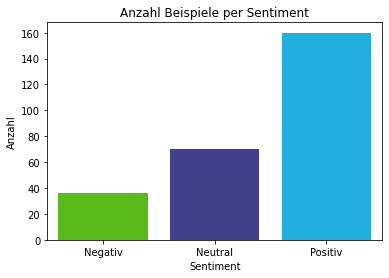

In [49]:
ax = sns.countplot(x='Sentiment_Text', data=df, palette=customPalette, order=['Negativ', 'Neutral', 'Positiv'] )
ax.set(xlabel="Sentiment", ylabel = "Anzahl", title="Anzahl Beispiele per Sentiment")

In [50]:
# check if there is more than one sentiment assigned to same sentence --> there is not
df.apply(lambda x: False if sum([x['Negative'], x['Neutral'], x['Positive']]) > 1 else True, axis=1).value_counts()

True    266
dtype: int64